In [14]:
import numpy as np
import pandas as pd
from sklearn import preprocessing
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import roc_auc_score
from tqdm import tqdm

from xgboost import XGBClassifier
from sklearn.metrics import roc_auc_score
from sklearn.preprocessing import StandardScaler
from sksurv.linear_model import CoxPHSurvivalAnalysis
from sklearn.feature_selection import SelectKBest
from sklearn.pipeline import Pipeline
from lifelines import CoxPHFitter
import shap
import xgboost
import matplotlib.pyplot as plt
import statistics as st
from bayes_opt import BayesianOptimization
from pyirr import intraclass_correlation
from lightgbm import LGBMClassifier
import warnings
warnings.filterwarnings("ignore", category=UserWarning)
warnings.filterwarnings("ignore", category=DeprecationWarning)
def warn(*args, **kwargs):
    pass
import warnings
warnings.warn = warn
from feature_utils.feature_classfication import data_normalization, data_normalization_apply_cohort1_to_all, lgb_evaluate_lgbm, lgb_evaluate_svm

from imblearn.over_sampling import SMOTE
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
from functools import partial
from sklearn.preprocessing import label_binarize

from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, f1_score, roc_auc_score, roc_curve, auc
import sys
import argparse

import csv
import os


In [23]:
def extract_features_and_params(file_path):
    """
    提取特征列表和参数字典列表。
    
    :param file_path: txt文件的路径
    :return: features_from_file - 特征列表
             params_from_file - 参数字典列表
    """
    import ast

    with open(file_path, 'r') as file:
        content = file.readlines()
        

    # 提取特征列表
    features_from_file = ast.literal_eval(content[1].strip())
    
    # 提取参数字典
    params_content = []
    params_flag = False
    for line in content:
        if '--Params--' in line:
            params_flag = True
            continue
        if params_flag:
            if line.strip():  # 忽略空行
                params_content.append(line.strip())
                

    # 解析参数字典
    params_from_file = []
    for line in params_content:
        try:
            param_dict = ast.literal_eval(line)
            params_from_file.append(param_dict)
        except (ValueError, SyntaxError):
            continue
                
    return features_from_file, params_from_file

In [24]:
radiomics_file = '/Users/wangpengcheng/Documents/MB_AI/new_3cls_radiomics_new.txt'
radiomics_file_c4 = '/Users/wangpengcheng/Documents/MB_AI/new_3cls_radiomics_cohort4_new.txt'
result_file = '/Users/wangpengcheng/Downloads/MB_LGBM_CLNC_FINAL_3CLS/LMDDissemination_Margin_Location_Water_AllDissemination_LMDPattern_FourthIn_SuperLMD_3rdVIRDissemination_InfraLMD_Enhance_EpendymalDissemination_Ependymal3Dissemination_Enhance_Percent_Hydro_Cyst_split_ep_tranf_dsmn_01292002.txt'
result_file_save = '/Users/wangpengcheng/Downloads/MB_LGBM_CLNC_FINAL_3CLS/LMDDissemination_Margin_Location_Water_AllDissemination_LMDPattern_FourthIn_SuperLMD_3rdVIRDissemination_InfraLMD_Enhance_EpendymalDissemination_Ependymal3Dissemination_Enhance_Percent_Hydro_Cyst_split_ep_tranf_dsmn_01292002.txt'
csv_result = '/Users/wangpengcheng/Downloads/MB_LGBM_CLNC_FINAL_3CLS/LMDDissemination_Margin_Location_Water_AllDissemination_LMDPattern_FourthIn_SuperLMD_3rdVIRDissemination_InfraLMD_Enhance_EpendymalDissemination_Ependymal3Dissemination_Enhance_Percent_Hydro_Cyst_split_ep_tranf_dsmn_01292002/results.csv'

In [25]:
# 读取特征文件为dataframe
three_cls_path = radiomics_file
three_cls_path_c4 = radiomics_file_c4
data = pd.read_csv(three_cls_path, sep='\t')
data_c4 = pd.read_csv(three_cls_path_c4, sep='\t')

# 从txt文件中读取特征名称和模型参数
file_path = result_file
print(file_path)
sel_columns_from_file, params_from_file = extract_features_and_params(file_path)

sel_columns = sel_columns_from_file

# 参数预处理，我们使用cohort1作为训练集进行三折训练，cohort2,3,4都是作为外部测试验证集
x = data[sel_columns]
x.iloc[:, 4:] = x.iloc[:, 4:].astype(float)
print(sel_columns, x.shape)

x_new = data_c4[sel_columns]
id_new = data_c4['id'].tolist()
print(sel_columns, x_new.shape)
x_new.iloc[:, 3:] = x_new.iloc[:, 3:].astype(float)
print('total features and labels shape: ', x.shape)

# split base dataset and external validation dataset
df_val = x[(x['Cohort'] == 2) | (x['Cohort'] == 3)]
df_val.reset_index(inplace=True)
X_val = df_val.iloc[:, 4:]

feature_names = X_val.columns.tolist()
print(feature_names)
X_val = np.array(X_val)
y_val = df_val['Subtypes_three']
y_val = np.array(y_val)

df_new = x_new
X_new = df_new.iloc[:, 3:]

feature_names = X_new.columns.tolist()
print(feature_names)
X_new = np.array(X_new)
y_new = df_new['Subtypes_three']
y_new = np.array(y_new)

print('X-val: ', X_val.shape)
print('X-new: ', X_new.shape)

# 训练集
df_X = x[x['Cohort'] == 1]
df_X.reset_index(inplace=True)

folds_indices = {}

# 从文件中读取已经划分好的fold情况
for fold in df_X['fold'].unique():
    test_index = df_X[df_X['fold'] == fold].index
    train_index = df_X[df_X['fold'] != fold].index
    print(len(test_index), len(train_index))
    folds_indices[fold] = {'train_index': train_index, 'test_index': test_index}

X = df_X.iloc[:, 4:]
y = df_X['Subtypes_three']
print('X: ', X.shape)
print('Fold index has been determined!')

/Users/wangpengcheng/Downloads/MB_LGBM_CLNC_FINAL_3CLS/LMDDissemination_Margin_Location_Water_AllDissemination_LMDPattern_FourthIn_SuperLMD_3rdVIRDissemination_InfraLMD_Enhance_EpendymalDissemination_Ependymal3Dissemination_Enhance_Percent_Hydro_Cyst_split_ep_tranf_dsmn_01292002.txt
['Cohort', 'Subtypes_three', 'fold', 'Age', 'LMDDissemination', 'Margin', 'Location', 'Water', 'AllDissemination', 'LMDPattern', 'FourthIn', 'SuperLMD', '3rdVIRDissemination', 'InfraLMD', 'Enhance', 'EpendymalDissemination', 'Ependymal3Dissemination', 'Enhance_Percent', 'Hydro', 'Cyst', 'T1E_log-sigma-3-mm-3D_gldm_LargeDependenceHighGrayLevelEmphasis_x', 'T1E_log-sigma-3-mm-3D_glcm_Autocorrelation_x', 'T1E_log-sigma-1-mm-3D_glcm_ClusterShade_x', 'T1E_wavelet-LHL_firstorder_Mean_x', 'T2_wavelet-LLH_glcm_ClusterShade_y', 'T1E_log-sigma-5-mm-3D_glrlm_LowGrayLevelRunEmphasis_x', 'T1E_wavelet-HLL_firstorder_Median_x', 'T1E_wavelet-LHL_firstorder_Median_x', 'T2_wavelet-HHL_firstorder_Skewness_x', 'T1E_log-sigma-3

In [26]:
params_best = params_from_file
        
test_folds = []
test_gt_folds = []
val_folds = []
true_folds = []
pred_folds = []
cm_folds = []
f1_test_folds = []
auc_test_folds = []
new_folds = []

for i, values in enumerate(folds_indices.values()):
    train_index, test_index = values['train_index'], values['test_index']
    X_train, y_train = X.iloc[train_index], y.iloc[train_index]
    X_test, y_test = X.iloc[test_index], y.iloc[test_index]

    X_train = np.array(X_train)
    X_test = np.array(X_test)

    y_train = np.array(y_train).astype(int)
    y_test = np.array(y_test).astype(int)

    X_train, y_train = X.iloc[train_index], y.iloc[train_index]
    X_test, y_test = X.iloc[test_index], y.iloc[test_index]

    X_train = np.array(X_train)
    X_test = np.array(X_test)

    y_train = np.array(y_train).astype(int)
    y_test = np.array(y_test).astype(int)

    # 这里需要注意的是采用了数据增广，所以最后用于拟合数据的训练集并不只是之前划分的X_train和y_train
    nm = SMOTE(random_state=42)
    X_res, y_res = nm.fit_resample(X_train, y_train)

    # 模型的参数以及拟合
    params_cur = params_best[i]
    modellgb = LGBMClassifier()
    modellgb.set_params(**params_cur)
    clf_lg = modellgb.fit(X_res, y_res)
    break

(135, 36)


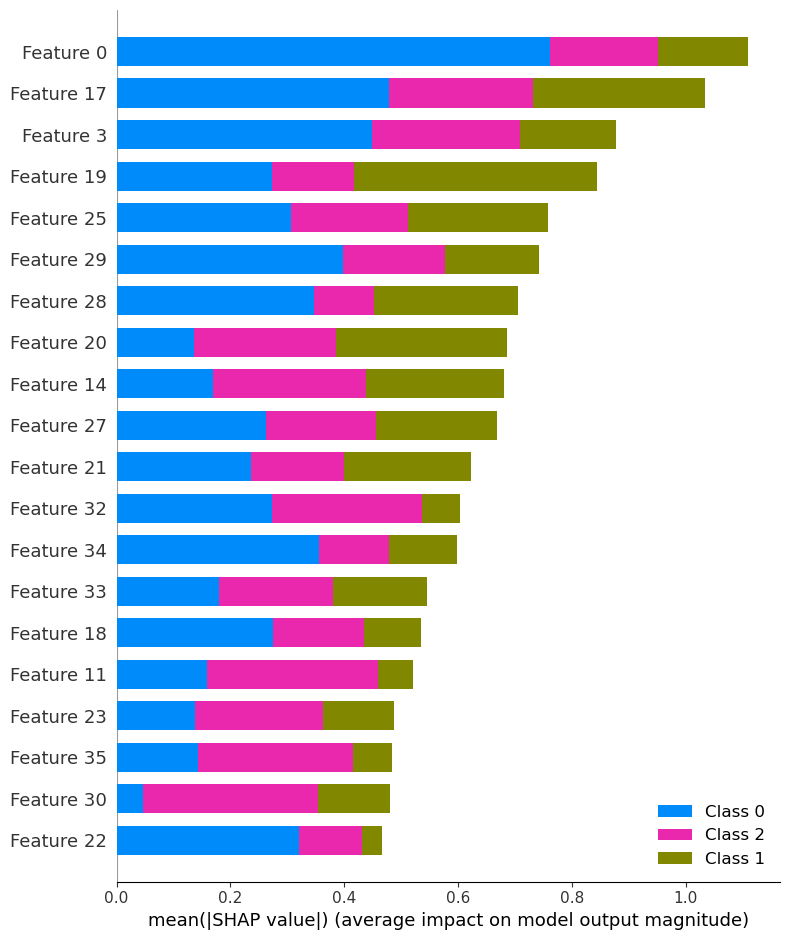

In [37]:
print(X_val.shape)
shap_values_Tree_tr = shap.TreeExplainer(clf_lg).shap_values(X_val)
shap.summary_plot(shap_values_Tree_tr, X_val)

In [38]:
print('Class0: ',shap_values_Tree_tr[0].shape,
      'Class1: ',shap_values_Tree_tr[1].shape,
      'Class2: ',shap_values_Tree_tr[2].shape)

Class0:  (135, 36) Class1:  (135, 36) Class2:  (135, 36)
